In [713]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from difflib import get_close_matches
from IPython.display import display
from matplotlib.ticker import ScalarFormatter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

## Preprocessing & data cleaning

**steps include:**
- renaming dataset columns to snake_case and english
- checking for missing values
- checking for potential outliers
- adding column country 
- validating text data
- converting date to integer

In [714]:
df = pd.read_csv("fotbal_prestupy_2000_2019.csv", encoding='utf-8')

In [715]:
df.head()

,Jméno,Pozice,Věk,Původní tým,Původní liga,Nový tým,Nová Liga,Sezóna,Odhadovaná hodnota,Přestupová částka
0,Luís Figo,Right Winger,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,2000-2001,NaN,60000000
1,Hernán Crespo,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,2000-2001,NaN,56810000
2,Marc Overmars,Left Winger,27,Arsenal,Premier League,FC Barcelona,LaLiga,2000-2001,NaN,40000000
3,Gabriel Batistuta,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,2000-2001,NaN,36150000
4,Nicolas Anelka,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,2000-2001,NaN,34500000


In [716]:
df.rename(columns={"Jméno": "name", 
                   "Pozice": "position", 
                   "Věk": "age", 
                   "Původní tým": "original_team", 
                   "Původní liga": "original_league",
                   "Nový tým": "new_team",
                   "Nová  Liga": "new_league",
                   "Sezóna": "season",
                   "Odhadovaná hodnota": "estimated_value",
                   "Přestupová částka": "transfer_fee"}, inplace=True)
df.head()

,name,position,age,original_team,original_league,new_team,new_league,season,estimated_value,transfer_fee
0,Luís Figo,Right Winger,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,2000-2001,NaN,60000000
1,Hernán Crespo,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,2000-2001,NaN,56810000
2,Marc Overmars,Left Winger,27,Arsenal,Premier League,FC Barcelona,LaLiga,2000-2001,NaN,40000000
3,Gabriel Batistuta,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,2000-2001,NaN,36150000
4,Nicolas Anelka,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,2000-2001,NaN,34500000


### Validating text columns 
First I want to check all the text columns and try to find possible typos which could lead to duplicities. For this I will use difflib function get_close_matches, which will be able to return similar enough cases and should cover typos and mistranslations. 

In [717]:
text_cols = ["name", "position", "original_team", "original_league", "new_team", "new_league"]

def preprocess_text(column):
    column = column.str.strip() # strip trailing spaces 
    column = column.str.replace("-"," ") # replace - with space
    column = column.str.replace("\n","") # remove newlines
    column = column.str.replace("\t","") # remove tabs
    column = column.str.lower() # all lowercase
    return column

In [718]:
for col in text_cols:
    df[col] = preprocess_text(df[col])

In [719]:
def get_similar_entities(unique_names):
    matches= []
    for i, name in enumerate(list(unique_names)):
        possible_match = get_close_matches(name, list(unique_names[i+1:]), cutoff=0.7)
        if possible_match:
            matches.append((name, possible_match))
    return matches

In [720]:
for col in ["team", "league"]:
    display(f"Similarities for {col}s:")
    display(get_similar_entities(pd.concat([df[f"original_{col}"], df[f"new_{col}"]]).unique()))

'Similarities for teams:'

[('fc barcelona', ['fc barcelona b', 'barcelona sc', 'fc basel']),
 ('parma', ['paraná']),
 ('arsenal', ['arsenal fc', 'arsenal u23', 'arsenal u18']),
 ('real madrid', ['real murcia']),
 ('west ham', ['west brom']),
 ('monaco', ['monza']),
 ('valencia cf', ['valencia b']),
 ('atlético madrid', ['atlético pr', 'atlético mg']),
 ('atlético pr', ['atlético mg']),
 ('chelsea', ['chelsea u23']),
 ('inter', ['inter u19']),
 ('benfica', ['benfica b', 'benfica u19']),
 ('sparta praha', ['sparta r.']),
 ('partizan', ['paraná']),
 ('sporting cp', ['sporting gijón']),
 ('são paulo', ['fc são paulo b']),
 ('racing', ['reading', 'racing club']),
 ('lens', ['león', 'le mans']),
 ('mk dons', ['mk dons u18']),
 ('internacional', ['nacional', 'ternana']),
 ('dinamo zagreb', ['nk zagreb', 'dinamo bukarest']),
 ('olympiacos', ['olimpia']),
 ('bolton', ['bologna']),
 ('juventus', ['juventude']),
 ('rangers', ['sco angers']),
 ('nacional', ['atl. nacional']),
 ('loko moscow', ['cska moscow', 'torpedo mosco

'Similarities for leagues:'

[('laliga', ['laliga2']),
 ('serie a', ['série a', 'serie b', 'serie c   a']),
 ('premier league', ['u18 premier league', 'super league', 'premier liga']),
 ('ligue 1', ['ligue 2', 'liga 1', 'rel. ligue 1']),
 ('serie b', ['série b', 'serie c   b', 'série a']),
 ('1.bundesliga', ['2.bundesliga', 'bundesliga']),
 ('liga nos', ['liga 1']),
 ('eredivisie', ['u19 eredivisie']),
 ('england', ['finland']),
 ('süper lig', ['superliga', 'superligaen']),
 ('croatia', ['romania']),
 ('super league',
  ['stars league', 'u18 premier league', 'jupiler pro league']),
 ('2.bundesliga', ['bundesliga']),
 ('1.lig', ['3.liga']),
 ('k league 1', ['j2 league', 'j1 league', 'league one']),
 ('serie c   a', ['serie c   b']),
 ('série a', ['série b']),
 ('superligaen', ['superliga']),
 ('j1 league', ['j2 league']),
 ('torneo final', ['torneo inicial']),
 ('2ª b   grupo iii', ['2ª b   grupo i']),
 ('liga mx clausura', ['liga mx apertura']),
 ('liga 1   championship group',
  ['a grupa   championship gr.', 'su

### Text cols revision results:
**Revision of close matches found out two mistakes:**
Al Shabab was in several instances named just Shabab
Al Nasr was in several instances named just Nasr

In [721]:
df.loc[df["original_team"] == "shabab", "original_team"] = "al shabab"
df.loc[df["new_team"] == "shabab", "original_team"] = "al shabab"

df.loc[df["original_team"] == "nasr", "original_team"] = "al nasr"
df.loc[df["new_team"] == "nasr", "new_team"] = "al nasr"

## Validating other columns 
looking into season, age, estimated_value and transfer_fee columns

In [722]:
df["season"] = df["season"].str.split("-", expand=True)[0] # take the starting year of season
df["season"] = df["season"].astype(int)

### Check validity of ages 

In [723]:
df["age"].sort_values(ascending=True) # There is one player who is 0 years old

236      0
1370    15
945     16
4502    16
1306    16
        ..
439     34
112     35
2954    35
487     35
2414    35
Name: age, Length: 4700, dtype: int64

There is one player with age 0. Assuming his parents did not sell his soul to a Saudi Arabian football club, I will impute this value with information available online. If there were more cases than just 1 and imputing with real data was too time consuming or impossible, I would use mean or median imputation. 

From his wikipedia page, I can see that he was 25 years old during his transfer from al shabab to ittihad

In [724]:
df[df["age"] == 0]

,name,position,age,original_team,original_league,new_team,new_league,season,estimated_value,transfer_fee
236,marzouq al otaibi,centre forward,0,al shabab,saudi arabia,ittihad,saudi arabia,2000,NaN,2000000


In [725]:
df.loc[df["age"] == 0, "age"] = 25

In [726]:
df["age"].isna().sum() 

0

### Check validity of season
The number and values of seasons matches. No validation to go through here.

In [727]:
df["season"].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

### Check validity of transfer_fee


In [728]:
df["transfer_fee"].isna().sum() # no missing values

0

In [729]:
df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,age,season,estimated_value,transfer_fee
count,4700.00,4700.00,3440.00,4700.00
mean,24.34,2009.00,8622469.48,9447586.17
std,3.21,5.47,8795180.75,10437719.32
min,15.00,2000.00,50000.00,825000.00
25%,22.00,2004.00,3500000.00,4000000.00
50%,24.00,2009.00,6000000.00,6500000.00
75%,27.00,2014.00,10000000.00,10820000.00
max,35.00,2018.00,120000000.00,222000000.00


### Check validity of estimated_value

In [730]:
df[df.isna().any(axis=1)] #1260 missing values -> all of them are in estimated_value 

,name,position,age,original_team,original_league,new_team,new_league,season,estimated_value,transfer_fee
0,luís figo,right winger,27,fc barcelona,laliga,real madrid,laliga,2000,NaN,60000000
1,hernán crespo,centre forward,25,parma,serie a,lazio,serie a,2000,NaN,56810000
2,marc overmars,left winger,27,arsenal,premier league,fc barcelona,laliga,2000,NaN,40000000
3,gabriel batistuta,centre forward,31,fiorentina,serie a,as roma,serie a,2000,NaN,36150000
4,nicolas anelka,centre forward,21,real madrid,laliga,paris sg,ligue 1,2000,NaN,34500000
...,...,...,...,...,...,...,...,...,...,...
4355,douglas luiz,central midfield,19,vasco da gama,série a,man city,premier league,2017,NaN,12000000
4427,jadon sancho,left winger,17,man city u18,u18 premier league,bor. dortmund,1.bundesliga,2017,NaN,7840000
4618,davide bettella,centre back,18,inter,serie a,atalanta,serie a,2018,NaN,7000000
4648,william bianda,centre back,18,lens,ligue 2,as roma,serie a,2018,NaN,6000000


There are missing values across all the years except 2015. 
Most of  them in 2000, 2001, 2002, 2003, 2004.

Possible solutions: 
   - Dropping the values
   - mean/median imputation 
   - regression imputation

In [731]:
df[df.isna().any(axis=1)]["season"].value_counts() 

season
2001    250
2000    248
2002    244
2003    242
2004    189
2005     28
2006     20
2007     13
2008      7
2010      4
2017      3
2018      3
2012      2
2013      2
2009      2
2014      1
2016      1
2011      1
Name: count, dtype: int64

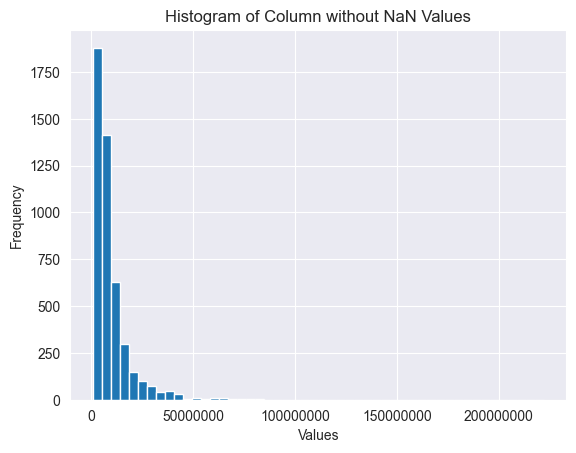

In [732]:
plt.hist(df["transfer_fee"].dropna(), bins=50)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Column without NaN Values')
plt.ticklabel_format(style='plain', axis='both')
plt.show()

### Outliers 
Checking for outliers is useful, as their presence could negatively affect models/statistical analysis etc. 
However due to this being only EDA task, while identifying and storing outliers, I will not remove them nor take any measures. On the contrary, I find them quite interesting to look at -> they could give us more insight into why these players are so expensive.
The main idea being not removing outliers from this dataset is that it is NOT randomly sampled - we are sampling the 250 most expensive football transfers in the year, it is natural that we get some extreme values that  all others. 

In [733]:
def get_outliers_iqr(df, column_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    boxplot = ax.boxplot(df[column_name], vert=False, patch_artist=True)

    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    lower_bound_ex = q1 - 3 * iqr
    upper_bound_ex = q3 + 3 * iqr

    outliers = df[((df[column_name] < lower_bound) & (df[column_name] >= lower_bound_ex)) | (
            (df[column_name] > upper_bound) & (df[column_name] <= upper_bound_ex))]
    ext_outliers = df[(df[column_name] < lower_bound_ex) | (df[column_name] > upper_bound_ex)]

    for patch in boxplot['boxes']:
        patch.set_facecolor('lightblue')

    ax.scatter(outliers[column_name], [1] * len(outliers), color='green', alpha=0.7, label='Outliers', s=15, marker='o')
    ax.scatter(ext_outliers[column_name], [1] * len(ext_outliers), color='red', alpha=0.7, label='Extreme Outliers', s=20, marker='x')

    ax.axvline(lower_bound_ex, color='orange', linestyle='--', label='Lower Bound (3*IQR)')
    ax.axvline(upper_bound_ex, color='orange', linestyle='--', label='Upper Bound (3*IQR)')

    ax.set_yticklabels([column_name])
    ax.set_xlabel('Values')
    ax.set_title(f'Boxplot for {column_name} with Outliers')

    ax.legend()

    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))

    plt.show()
    
    return pd.concat([outliers, ext_outliers])
    

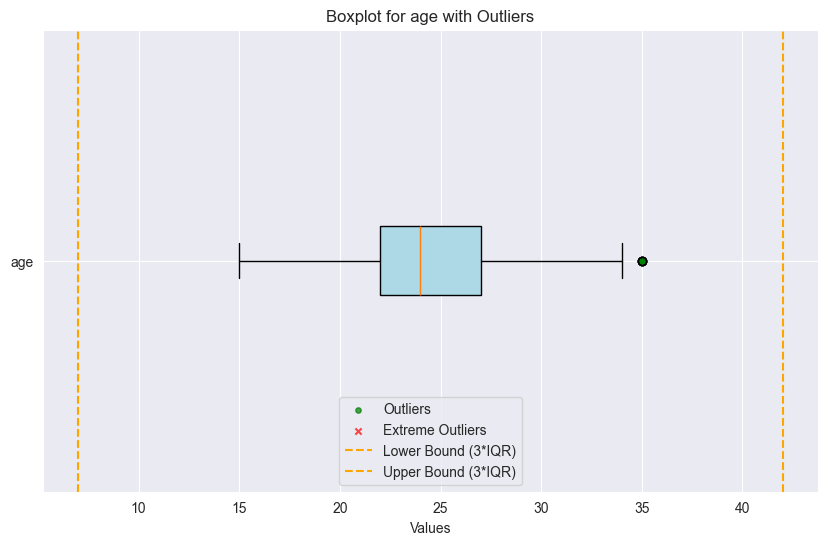

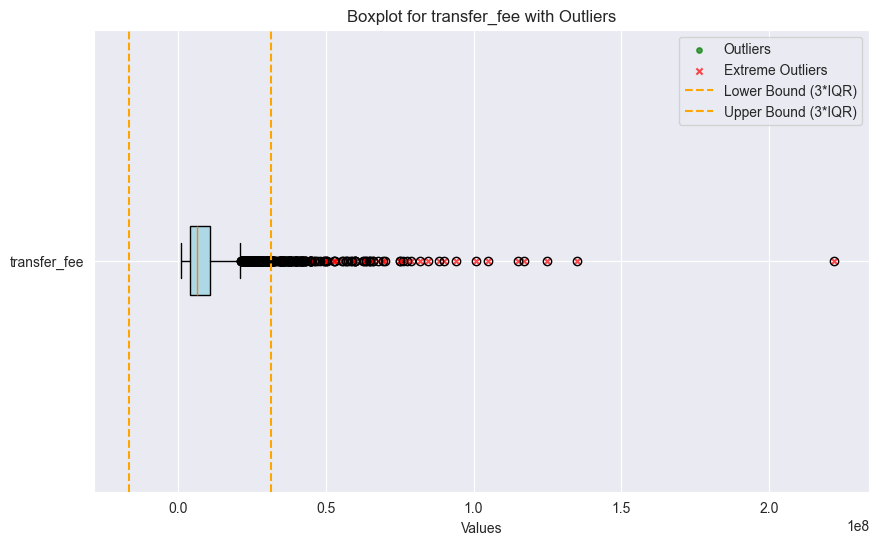

In [734]:
get_outliers_iqr(df, "age")
outliers = get_outliers_iqr(df, "transfer_fee")

In [745]:
outliers.sort_values(by=["transfer_fee"], ascending=False)

,name,position,age,original_team,original_league,new_team,new_league,season,estimated_value,transfer_fee
4211,neymar,left winger,25,fc barcelona,laliga,paris sg,ligue 1,2017,100000000.0,222000000
4455,kylian mbappé,right winger,19,monaco,ligue 1,paris sg,ligue 1,2018,120000000.0,135000000
4212,philippe coutinho,attacking midfield,25,liverpool,premier league,fc barcelona,laliga,2017,90000000.0,125000000
4456,cristiano ronaldo,centre forward,33,real madrid,laliga,juventus,serie a,2018,100000000.0,117000000
4213,ousmane dembélé,right winger,20,bor. dortmund,1.bundesliga,fc barcelona,laliga,2017,33000000.0,115000000
...,...,...,...,...,...,...,...,...,...,...
4271,manuel akanji,centre back,22,fc basel,super league,bor. dortmund,1.bundesliga,2017,5000000.0,21500000
4270,luis muriel,centre forward,26,sampdoria,serie a,sevilla fc,laliga,2017,17000000.0,21500000
12,lucas,centre forward,21,atlético pr,brazil,stade rennais,ligue 1,2000,NaN,21300000
13,pablo aimar,attacking midfield,21,river plate,argentina,valencia cf,laliga,2000,NaN,21250000


### Imputing missing values

For handling missing values I decided to go with regression imputation. Imputing with mean or median values for estimated_value column would make little to no sense as there clearly is a correlation between the *estimated_value* and *transfer_fee* and we should account for that. I decided to go with a simple model with only one explanatory variable and that being *transfer_fee*. Other values such as the player position could be added for more complex model. Needless to say, with R^2 ~ 0.73, the model does a sufficiently good job at imputing the missing values.

R-squared (R2): 0.7295
Mean Squared Error (MSE): 19787873618589.1445
Root Mean Squared Error (RMSE): 4448356.2828


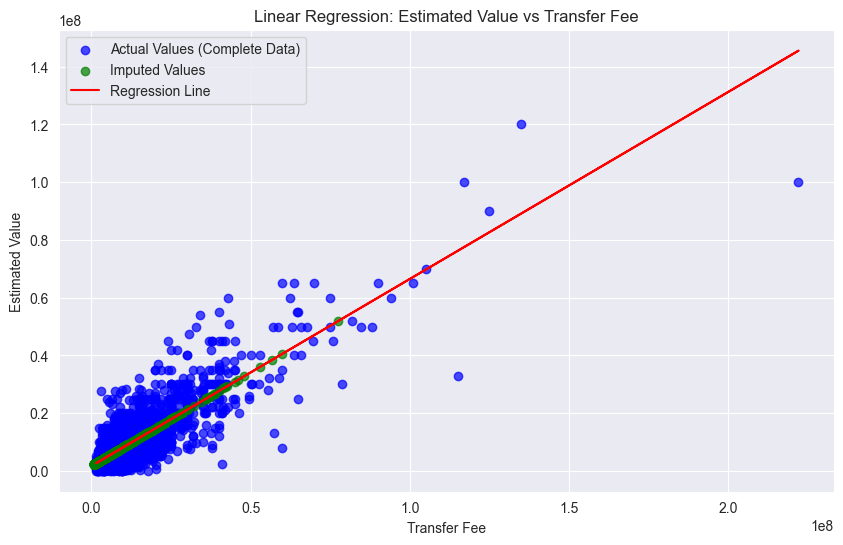

In [735]:
df_copy = pd.get_dummies(df, columns=['position'])
df_complete = df_copy.dropna(subset=['estimated_value'])
df_incomplete = df_copy[df_copy['estimated_value'].isnull()]

X_cols = ['transfer_fee']

X = df_complete[X_cols]
y = df_complete['estimated_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

plt.figure(figsize=(10, 6))

plt.scatter(df_complete['transfer_fee'], y, color='blue', alpha=0.7, label='Actual Values (Complete Data)')
plt.scatter(df_incomplete['transfer_fee'], model.predict(df_incomplete[X_cols]), color='green', alpha=0.7, label='Imputed Values')
plt.plot(df_complete['transfer_fee'], model.predict(X), color='red', label='Regression Line')

plt.title('Linear Regression: Estimated Value vs Transfer Fee')
plt.xlabel('Transfer Fee')
plt.ylabel('Estimated Value')
plt.legend()
plt.show()
df.loc[df['estimated_value'].isnull(), 'estimated_value'] = model.predict(df_incomplete[X_cols])

### Deriving feature country
**While league and team may be useful identificators of the background, it may not always be clear where the team is from as we have 615 unique teams. I decided to engineer a features "origin_country" and "target_country", that will represent the countries of the original and target teams, respectively.**

**For this I decided to use GPT 3.5 from OpenAI with the prompt:**
*"You will be presented with a list of football teams. I want you to assign the country of origin to them. Provide me with an output in the form of a python dictionary. E.g. {"Chelsea": "England", "Bayern": "Germany"}. If you are not sure what country the team is from, type "unknown"."*


**Outputs from the language model were saved into *countries.json* file.** 

In [736]:
pd.concat([df["original_team"], df["new_team"]]).unique()  # output from this list was used in the prompt to generate the feature country

array(['fc barcelona', 'parma', 'arsenal', 'fiorentina', 'real madrid',
       'west ham', 'dep. la coruña', 'real zaragoza', 'monaco',
       'valencia cf', 'atlético madrid', 'atlético pr', 'river plate',
       'boca juniors', 'stade rennais', 'coventry city',
       'cagliari calcio', 'bay. leverkusen', 'chelsea', 'dynamo kyiv',
       'inter', 'rcd mallorca', 'g. bordeaux', 'fc porto', 'benfica',
       'lazio', 'real betis', 'everton', 'sparta praha', 'málaga cf',
       'partizan', 'celta de vigo', 'sporting cp', 'aston villa',
       'afc ajax', 'são paulo', 'marseille', 'racing', 'lens', 'mk dons',
       'cd tenerife', 'norwich', 'celtic', 'fenerbahce', 'middlesbrough',
       'internacional', 'leicester', 'rosenborg bk', 'dinamo zagreb',
       'feyenoord', 'grasshoppers', 'olympiacos', 'bolton', 'reggina',
       'juventus', 'fluminense', 'lecce', 'liverpool', 'cd cruz azul',
       'u. de chile', 'ponte preta', 'vitesse', 'galatasaray',
       'montpellier', 'roda jc', 're

In [737]:
with open("countries.json", "r", encoding="utf-8") as f:
    countries = json.load(f)

In [738]:
df_countries = pd.DataFrame.from_dict(countries.items())
df_countries.columns =["team", "country"]
df_countries["team"] = preprocess_text(df_countries["team"])
df_countries["country"] = preprocess_text(df_countries["country"])

In [739]:
df = pd.merge(df, df_countries, left_on=['new_team'], right_on=['team'], how='left')
df = pd.merge(df, df_countries, left_on=['original_team'], right_on=['team'], how='left', suffixes=('_new', '_original'))
df.drop(['team_new', 'team_original'], axis=1, inplace=True)
df.rename(columns={'country_new': 'new_country', 'country_original': 'original_country'}, inplace=True)

In [740]:
df.head()

,name,position,age,original_team,original_league,new_team,new_league,season,estimated_value,transfer_fee,new_country,original_country
0,luís figo,right winger,27,fc barcelona,laliga,real madrid,laliga,2000,4.054839e+07,60000000,spain,spain
1,hernán crespo,centre forward,25,parma,serie a,lazio,serie a,2000,3.848102e+07,56810000,italy,italy
2,marc overmars,left winger,27,arsenal,premier league,fc barcelona,laliga,2000,2.758684e+07,40000000,spain,england
3,gabriel batistuta,centre forward,31,fiorentina,serie a,as roma,serie a,2000,2.509174e+07,36150000,italy,italy
4,nicolas anelka,centre forward,21,real madrid,laliga,paris sg,ligue 1,2000,2.402242e+07,34500000,france,spain
